In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, initializers

import warnings
warnings.filterwarnings("ignore")

import BjerksundStenslandModel as BS
from EnsembleNeuralNetworks import ENN
# from BlackScholesModel.py import black_scholes_call_option, black_scholes_put_option

In [2]:
# Read the data
df = pd.read_csv('/Users/gaojinglun/Desktop/RSG/data/ES_EZ.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Put.Call,Strike.Price,Settlement,Historical Vol,futures.price,Time.to.maturity,Risk.Free.Rate,Open.Interest,Implied.Volatility,Moneyness
0,C,2200,1059.0,0.008335,3259.0,0.213699,0.0154,826.0,0.338267,ITM
1,C,2250,1009.1,0.008335,3259.0,0.213699,0.0154,728.0,0.326829,ITM
2,C,2270,989.1,0.008335,3259.0,0.213699,0.0154,1.0,0.323456,ITM
3,C,2300,959.2,0.008335,3259.0,0.213699,0.0154,212.0,0.317834,ITM
4,C,2310,949.2,0.008335,3259.0,0.213699,0.0154,42.0,0.314282,ITM


In [3]:
# Set the number of estimators in the ensemble learning
n_estimators = 10

Xcol = ['Put.Call', 'futures.price', 'Strike.Price', 'Time.to.maturity', 'Risk.Free.Rate',
        'Historical Vol', 'Open.Interest', 'ATM', 'ITM', 'OTM']
Ycol = 'Implied.Volatility'

### Call Options

In [4]:
ES_EZ_call = df[df['Put.Call'] == 'C']
ES_EZ_call['Put.Call'] = np.zeros(ES_EZ_call.shape[0])

Call_temp = 100 * ES_EZ_call['Strike.Price'].values / ES_EZ_call['futures.price'].values
Call_ITM_idx = Call_temp < 95.2
Call_ATM_idx = np.logical_and(Call_temp <= 103.1, Call_temp >= 95.2)
Call_OTM_idx = Call_temp > 103.1

Call_moneyness = pd.get_dummies(ES_EZ_call['Moneyness'])
ES_EZ_call = pd.concat([ES_EZ_call, Call_moneyness], axis = 1)

In [5]:
ES_EZ_put = df[df['Put.Call'] == 'P']
ES_EZ_put['Put.Call'] = np.ones(ES_EZ_put.shape[0])

Put_temp = 100 * ES_EZ_put['Strike.Price'].values / ES_EZ_put['futures.price'].values
Put_ITM_idx = Put_temp > 103
Put_ATM_idx = np.logical_and(Put_temp < 103, Put_temp >= 95.2)
Put_OTM_idx = Put_temp < 95.2

put_moneyness = pd.get_dummies(ES_EZ_put['Moneyness'])
ES_EZ_put = pd.concat([ES_EZ_put, put_moneyness], axis = 1)

In [6]:
data = pd.concat([ES_EZ_call, ES_EZ_put], axis = 0)
print(data.shape)
data.head()

(27239, 13)


,Put.Call,Strike.Price,Settlement,Historical Vol,futures.price,Time.to.maturity,Risk.Free.Rate,Open.Interest,Implied.Volatility,Moneyness,ATM,ITM,OTM
0,0.0,2200,1059.0,0.008335,3259.0,0.213699,0.0154,826.0,0.338267,ITM,0,1,0
1,0.0,2250,1009.1,0.008335,3259.0,0.213699,0.0154,728.0,0.326829,ITM,0,1,0
2,0.0,2270,989.1,0.008335,3259.0,0.213699,0.0154,1.0,0.323456,ITM,0,1,0
3,0.0,2300,959.2,0.008335,3259.0,0.213699,0.0154,212.0,0.317834,ITM,0,1,0
4,0.0,2310,949.2,0.008335,3259.0,0.213699,0.0154,42.0,0.314282,ITM,0,1,0


In [7]:
ENN_model = ENN(n_estimators = n_estimators, inputShape = 10)
ENN_model.bootstrap(data = data, 
                   stratification = data['Moneyness'], trainsize = 0.8)
LR = [1e-2, 1e-3]
ENN_model.fit(LR, Xcol, Ycol)

In [8]:
ENN_model.get_results()

The training R^2 for model 0 is 0.9654 and 0.9657, respectively
The training R^2 for model 1 is 0.9587 and 0.9592, respectively
The training R^2 for model 2 is 0.9641 and 0.9649, respectively
The training R^2 for model 3 is 0.9517 and 0.9502, respectively
The training R^2 for model 4 is 0.9711 and 0.9696, respectively
The training R^2 for model 5 is 0.963 and 0.9622, respectively
The training R^2 for model 6 is 0.9533 and 0.9508, respectively
The training R^2 for model 7 is 0.9643 and 0.9637, respectively
The training R^2 for model 8 is 0.9611 and 0.9601, respectively
The training R^2 for model 9 is 0.9642 and 0.9608, respectively


In [9]:
print('The training R^2 for call option is {} +/- {}.'.format(np.round(np.mean(ENN_model.results[:,0]), 4), 
                                                          np.round(np.std(ENN_model.results[:,0]), 4)))
print('The testing R^2 for call option is {} +/- {}.'.format(np.round(np.mean(ENN_model.results[:,1]), 4), 
                                                          np.round(np.std(ENN_model.results[:,1]), 4)))

The training R^2 for call option is 0.9617 +/- 0.0055.
The testing R^2 for call option is 0.9607 +/- 0.0059.


In [10]:
ENN_model.results

array([[0.9654, 0.9657],
       [0.9587, 0.9592],
       [0.9641, 0.9649],
       [0.9517, 0.9502],
       [0.9711, 0.9696],
       [0.963 , 0.9622],
       [0.9533, 0.9508],
       [0.9643, 0.9637],
       [0.9611, 0.9601],
       [0.9642, 0.9608]])

In [11]:
ES_EZ_X = data[Xcol]
ES_EZ_y = data[Ycol]

scalerX = MinMaxScaler().fit(ES_EZ_X)
ES_EZ_X = pd.DataFrame(scalerX.transform(ES_EZ_X), columns = ES_EZ_X.columns.values) 
scalery = MinMaxScaler().fit(ES_EZ_y.values.reshape(-1, 1))
ES_EZ_y = scalery.transform(ES_EZ_y.values.reshape(-1, 1))

In [12]:
result = np.round(r2_score(ES_EZ_y, ENN_model.predict(ES_EZ_X)), 4)
print('The total variance of call option impied volatility explained by the model is {}.'.format(result))

The total variance of call option impied volatility explained by the model is 0.9728.


In [13]:
Call_ITM = ES_EZ_call['Settlement'][Call_ITM_idx]
Call_ATM = ES_EZ_call['Settlement'][Call_ATM_idx]
Call_OTM = ES_EZ_call['Settlement'][Call_OTM_idx]
Call_ALL = ES_EZ_call['Settlement']

Put_ITM = ES_EZ_put['Settlement'][Put_ITM_idx]
Put_ATM = ES_EZ_put['Settlement'][Put_ATM_idx]
Put_OTM = ES_EZ_put['Settlement'][Put_OTM_idx]
Put_ALL = ES_EZ_put['Settlement']

def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100* np.mean(np.abs((y_true - y_pred) / y_true))

def Call_Results(Call_Pred):
    '''
    Get the results for Call options (TIM, ATM, OTM, and Overall) in terms of the R^2, MAE, MAPE 
    '''
    result = np.array([
        r2_score(Call_ITM, Call_Pred[Call_ITM_idx]),
        r2_score(Call_ATM, Call_Pred[Call_ATM_idx]),
        r2_score(Call_OTM, Call_Pred[Call_OTM_idx]),
        r2_score(Call_ALL, Call_Pred),
        
        mean_absolute_error(Call_ITM, Call_Pred[Call_ITM_idx]),
        mean_absolute_error(Call_ATM, Call_Pred[Call_ATM_idx]),
        mean_absolute_error(Call_OTM, Call_Pred[Call_OTM_idx]),
        mean_absolute_error(Call_ALL, Call_Pred),
        
        mean_absolute_percentage_error(Call_ITM, Call_Pred[Call_ITM_idx]),
        mean_absolute_percentage_error(Call_ATM, Call_Pred[Call_ATM_idx]),
        mean_absolute_percentage_error(Call_OTM, Call_Pred[Call_OTM_idx]),
        mean_absolute_percentage_error(Call_ALL, Call_Pred)
    ])
    result = np.round(result, 5)
    print('The R^2 for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[0], result[1], result[2], result[3])
    ) 
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAE for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[4], result[5], result[6], result[7])
    )
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAPE for ITM, ATM, OTM, and overall Call Option is {}, {}, {}, and {}, respectively.'.format(
        result[8], result[9], result[10], result[11])
    )
    print('--------------------------------------------------------------------------------------------------------')
    
    sns.displot(ES_EZ_call, x = np.abs(Call_ALL - Call_Pred), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.xlim(0,50)
    plt.title('Histogram of Absolute Error with respect to moneyness (exclude the extreme values)')
    
    sns.displot(ES_EZ_call, x = np.abs((Call_ALL - Call_Pred) / Call_ALL), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Count')
    plt.xlim(0,1)
    plt.title('Histogram of Absolute Percentage Error in 100% with respect to moneyness (exclude the extreme values)')

    return None

def Put_Results(Put_Pred):
    '''
    Get the results for Put options (TIM, ATM, OTM, and Overall) in terms of the R^2, MAE, MAPE
    '''

    result = np.array([
        r2_score(Put_ITM, Put_Pred[Put_ITM_idx]),
        r2_score(Put_ATM, Put_Pred[Put_ATM_idx]),
        r2_score(Put_OTM, Put_Pred[Put_OTM_idx]),
        r2_score(Put_ALL, Put_Pred),
        
        mean_absolute_error(Put_ITM, Put_Pred[Put_ITM_idx]),
        mean_absolute_error(Put_ATM, Put_Pred[Put_ATM_idx]),
        mean_absolute_error(Put_OTM, Put_Pred[Put_OTM_idx]),
        mean_absolute_error(Put_ALL, Put_Pred),
        
        mean_absolute_percentage_error(Put_ITM, Put_Pred[Put_ITM_idx]),
        mean_absolute_percentage_error(Put_ATM, Put_Pred[Put_ATM_idx]),
        mean_absolute_percentage_error(Put_OTM, Put_Pred[Put_OTM_idx]),
        mean_absolute_percentage_error(Put_ALL, Put_Pred)
    ])
    result = np.round(result, 5)
    print('The R^2 for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[0], result[1], result[2], result[3])
    ) 
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAE for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[4], result[5], result[6], result[7])
    )
    print('--------------------------------------------------------------------------------------------------------')
    print('The MAPE for ITM, ATM, OTM, and overall Put Option is {}, {}, {}, and {}, respectively.'.format(
        result[8], result[9], result[10], result[11])
    )
    print('--------------------------------------------------------------------------------------------------------')
    
    sns.displot(ES_EZ_put, x = np.abs(Put_ALL - Put_Pred), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.xlim(0,50)
    plt.title('Histogram of Absolute Error with respect to moneyness (exclude the extreme values)')
    
    sns.displot(ES_EZ_put, x = np.abs((Put_ALL - Put_Pred) / Put_ALL), 
                hue = "Moneyness", legend = True, height = 5, aspect = 2)
    plt.xlabel('Absolute Percentage Error')
    plt.ylabel('Count')
    plt.xlim(0,1)
    plt.title('Histogram of Absolute Percentage Error in 100% with respect to moneyness (exclude the extreme values)')

    return None

In [14]:
pred = ENN_model.predict(data[Xcol])
ENN_call = scalery.inverse_transform(pred[data['Put.Call'] == 0])
ENN_put = scalery.inverse_transform(pred[data['Put.Call'] == 1])

### Results

In [15]:
# Test the performances of ENN 
ENN_Call_Pred = np.zeros(ES_EZ_call.shape[0])
for i in range(ES_EZ_call.shape[0]):
    price = BS._american_option(option_type = 'c', 
                             fs = ES_EZ_call['futures.price'].values[i], 
                             x = ES_EZ_call['Strike.Price'].values[i], 
                             t = ES_EZ_call['Time.to.maturity'].values[i], 
                             r = ES_EZ_call['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ENN_call[i])[0]
    ENN_Call_Pred[i] = price

ENN_PUT_Pred = np.zeros(ES_EZ_put.shape[0])
for i in range(ES_EZ_put.shape[0]):
    price = BS._american_option(option_type = 'p', 
                             fs = ES_EZ_put['futures.price'].values[i], 
                             x = ES_EZ_put['Strike.Price'].values[i], 
                             t = ES_EZ_put['Time.to.maturity'].values[i], 
                             r = ES_EZ_put['Risk.Free.Rate'].values[i], 
                             b = 0, 
                             v = ENN_put[i])[0]
    ENN_PUT_Pred[i] = price


print('The total variance explained is {} for the Call Options'.format(
    np.round(r2_score(ES_EZ_call['Settlement'], ENN_Call_Pred), 5))
     )
print('The total variance explained is {} for the Put Options'.format(
    np.round(r2_score(ES_EZ_put['Settlement'], ENN_PUT_Pred), 5))
     )

The total variance explained is 0.96943 for the Call Options
The total variance explained is 0.84138 for the Put Options


The R^2 for ITM, ATM, OTM, and overall Call Option is 0.96707, -0.42164, -0.22418, and 0.96943, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Call Option is 44.22773, 89.5647, 35.76746, and 49.40988, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Call Option is 9.09402, 53.15945, 92.05383, and 42.75998, respectively.
--------------------------------------------------------------------------------------------------------


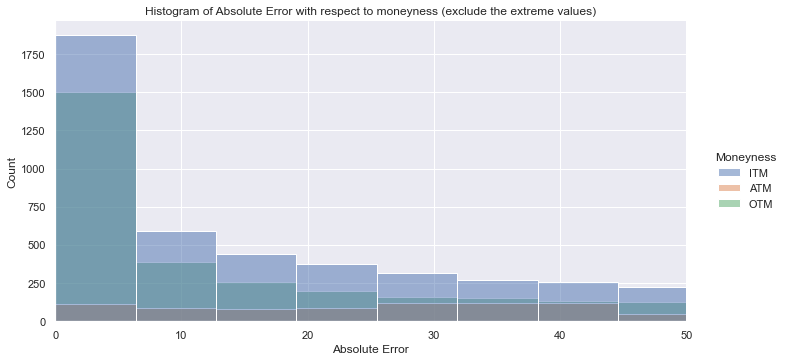

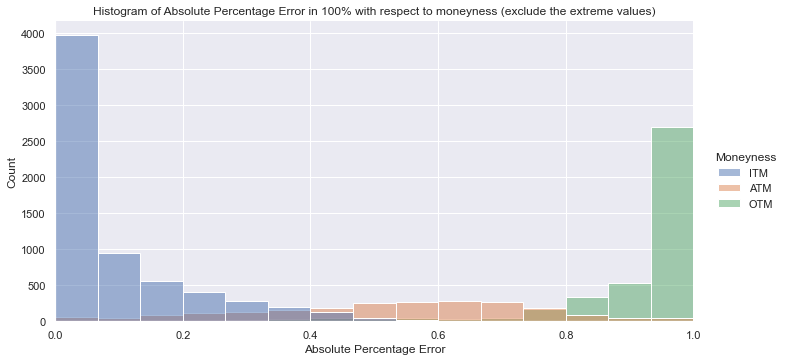

In [16]:
Call_Results(ENN_Call_Pred)

In [17]:
MAE_idx = np.argmax(np.abs(Call_ALL - ENN_Call_Pred))
print(ES_EZ_call.iloc[MAE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_Call_Pred[MAE_idx], 4))

Put.Call                      0
Strike.Price               2350
Settlement                373.6
Historical Vol        0.0158331
futures.price            2381.5
Time.to.maturity       0.758904
Risk.Free.Rate           0.0029
Open.Interest                19
Implied.Volatility     0.436856
Moneyness                   ATM
ATM                           1
ITM                           0
OTM                           0
Name: 2072, dtype: object
--------------------------------
The predicted value is 86.9344


In [18]:
MAPE_idx = np.argmax(np.abs((Call_ALL - ENN_Call_Pred) / Call_ALL))
print(ES_EZ_call.iloc[MAPE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_Call_Pred[MAPE_idx], 4))

Put.Call                      0
Strike.Price               3640
Settlement                 0.15
Historical Vol        0.0309739
futures.price            3065.1
Time.to.maturity      0.0493151
Risk.Free.Rate           0.0141
Open.Interest               103
Implied.Volatility     0.268086
Moneyness                   OTM
ATM                           0
ITM                           0
OTM                           1
Name: 1501, dtype: object
--------------------------------
The predicted value is 0.0


The R^2 for ITM, ATM, OTM, and overall Put Option is 0.88596, -0.79778, -0.55942, and 0.84138, respectively.
--------------------------------------------------------------------------------------------------------
The MAE for ITM, ATM, OTM, and overall Put Option is 44.56217, 89.88776, 38.79049, and 47.72527, respectively.
--------------------------------------------------------------------------------------------------------
The MAPE for ITM, ATM, OTM, and overall Put Option is 13.43577, 65.60003, 99.26621, and 76.79783, respectively.
--------------------------------------------------------------------------------------------------------


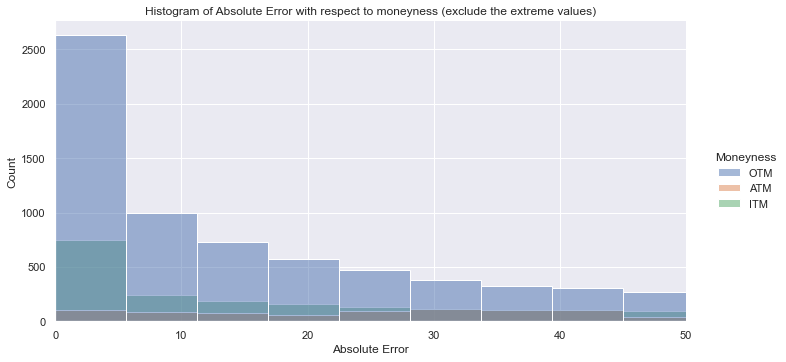

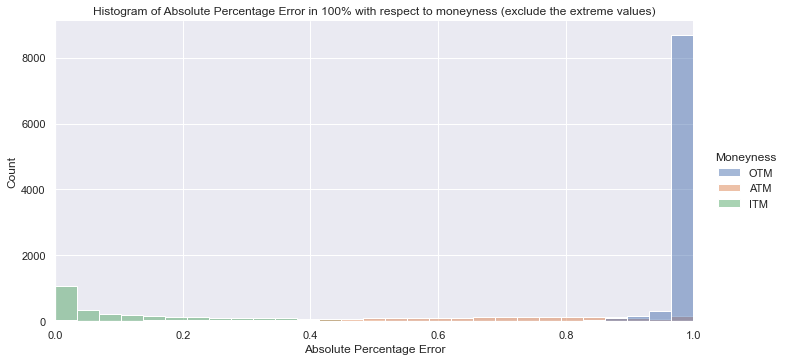

In [19]:
Put_Results(ENN_PUT_Pred)

In [20]:
MAE_idx = np.argmax(np.abs(Put_ALL - ENN_PUT_Pred))
print(ES_EZ_put.iloc[MAE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_PUT_Pred[MAE_idx], 4))

Put.Call                      1
Strike.Price               2350
Settlement                342.1
Historical Vol        0.0158331
futures.price            2381.5
Time.to.maturity       0.758904
Risk.Free.Rate           0.0029
Open.Interest              1585
Implied.Volatility     0.436856
Moneyness                   ATM
ATM                           1
ITM                           0
OTM                           0
Name: 15199, dtype: object
--------------------------------
The predicted value is 55.5031


In [21]:
MAPE_idx = np.argmax(np.abs((Put_ALL - ENN_PUT_Pred) / Put_ALL))
print(ES_EZ_put.iloc[MAPE_idx])
print('--------------------------------')
print('The predicted value is', np.round(ENN_PUT_Pred[MAPE_idx], 4))

Put.Call                       1
Strike.Price                1500
Settlement                   0.1
Historical Vol        0.00833466
futures.price               3259
Time.to.maturity        0.213699
Risk.Free.Rate            0.0154
Open.Interest               1670
Implied.Volatility      0.521792
Moneyness                    OTM
ATM                            0
ITM                            0
OTM                            1
Name: 12796, dtype: object
--------------------------------
The predicted value is 0.0
